# Линейная регрессия
Шестаков А.В. Майнор по анализу данных - 01/03/2016

Сегодня мы рассмотрим следующие темы:

1. Постановка задачи линейной регрессии
2. Преобразование переменных и интерпретация
3. Переобучение\недообучение, мультиколлинеарность и регуляризация

## 1. Постановка задачи

Дано описание $n$ объектов по $m$ признакам. Обычно оно выражается в виде матрицы размера $n \times m$: $X = [x^{(i)}_j]^{i=1\dots n}_{j=1\dots m} $.<br\> ($x^{(i)}_j$ означает $j$-ый признак $i$-го объекта) <br\>
Дана **вещественная** зависимая переменная, которая тоже имеет отношение к этим объекам: $y \in \mathbb{R}^n$.

Наша задача, выявить **линейную** зависимость между признаками в $X$ и значениями в $y$:
$$\hat{y} = X\beta \quad \Leftrightarrow \quad \hat{y}^{(i)} = \beta_0 + \beta_1x^{(i)}_1 + \dots$$
То есть необходимо оценить коэффициенты $\beta_i$.

В случае линейной регрессии коэффициенты $\beta_i$ рассчитываются так, чтобы минимизировать сумму квадратов ошибок по всем наблюдениям:
$$ L(\beta) = \frac{1}{2n}(\hat{y} - y)^{\top}(\hat{y} - y) = \frac{1}{2n}(X\beta - y)^{\top}(X\beta - y) \rightarrow \min$$ $$ \Updownarrow $$  $$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2 = \frac{1}{2n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 + \dots - y^{(i)})^2  \rightarrow \min $$

Мы уже знаем несколько способов решения этой задачи (Семинар 4):
* Градиентный спуск 
* Normal Equations (Проекционные матрицы)

### Библиотеки для расчетов

Самыми распространенными библиотеками в `Python` для работы с линейными методами (регрессии и классификации) являются [`scikit-learn`](http://scikit-learn.org/stable/) и [`statmodels`](http://statsmodels.sourceforge.net/). Так как в дальнейшем мы скорее всего будем работать со `scikit-learn`, то и примеры по большей части будут демонстрироваться именно в нем.

### Пример: Стоимость автомобиля

Загрузите [данные](http://bit.ly/1gIQs6C) по характеристикам автомобилей Honda Accord. Названия столбцов говорят сами за себя.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

%matplotlib inline

In [2]:
df = pd.read_csv('http://bit.ly/1gIQs6C')

In [3]:
df.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


Выберем одну переменную mileage в качестве предиктора, а переменную price в качестве зависимой переменной

In [4]:
y = df.price.values
X = df.mileage.values.reshape(-1,1)
# В последних версиях sklearn начинает ругаться на одномерные данные (когда array.shape = (m,))
# Поэтому с помошщью .reshape(-1,1) мы искусственно добавляем единичную размерность к Х

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
print('Модель:\nprice = %.2f + (%.2f)*mileage' % (model.intercept_, model.coef_[0]))

Модель:
price = 16762.02 + (-0.05)*mileage


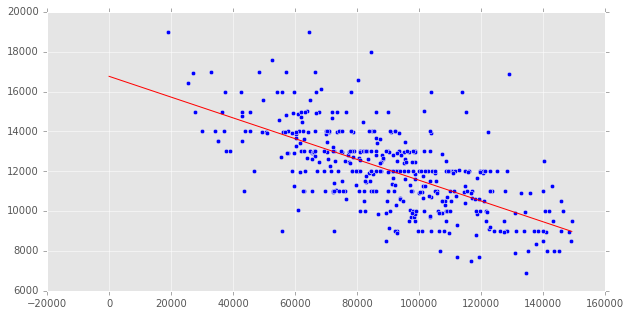

In [9]:
x = np.linspace(0, max(X), 100)
y_line = model.intercept_ + model.coef_[0]*x

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X, y)

ax.plot(x, y_line, c='red')



### Остатки и меры качества

Давайте взглянем на ошибки (остатки)

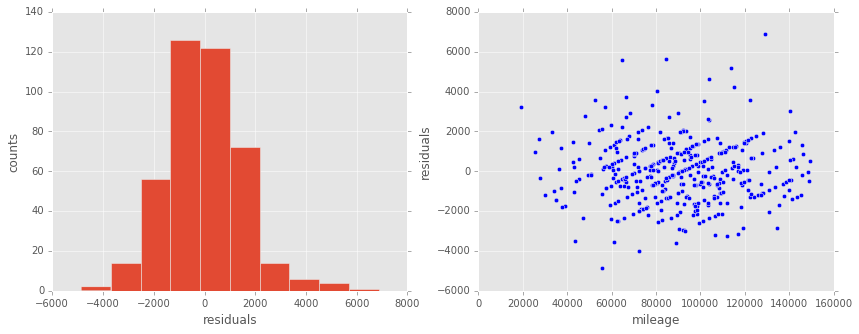

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

y_hat = model.predict(X)
res = y - y_hat
ax[0].hist(res)
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('counts')

ax[1].scatter(X, res)
ax[1].set_xlabel('mileage')
ax[1].set_ylabel('residuals')


Важно смотреть на остатки.<br/> 
Во-первых, они должны быть нормально распределены (Теорема Гаусса-Маркова).<br/>
Во-вторых, не должно быть ярких зависимостей между значениями признака и остатками.

Посмотрим на меры качества

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Можно посчитать простые варианты агрегирования остатков, например:

* $\frac{1}{n} \sum_i |\hat{y}^{(i)}-y^{(i)}|$ - средняя абсолютная ошибка
* $\frac{1}{n} \sum_i (\hat{y}^{(i)}-y^{(i)})^2$ - средняя квадратичная ошибка

In [13]:
print('Средняя абсолютная ошибка %.2f' % mean_absolute_error(y, y_hat))
print('Средняя квадратичная ошибка %.2f' % mean_squared_error(y, y_hat))

Средняя абсолютная ошибка 1182.21
Средняя квадратичная ошибка 2412292.55


Можно рассмотреть более сложную меру: коэффициент детерминации $R^2$:

* $TSS = \sum_i (y^{(i)}-\bar{y})^2$ - общая сумма квадратов (total sum of squares)
* $RSS = \sum_i (\hat{y}^{(i)}-y^{(i)})^2$ - сумма квадратов остатков (residual sum of squares)
* $ESS = \sum_i (\hat{y}^{(i)}-\bar{y})^2$ - объясненная сумма квадратов (explained sum of squares)

Для простоты будем считать, что
$$TSS = ESS + RSS$$

Тогда Коэффициент детерминации $R^2=1-\frac{RSS}{TSS}$


In [14]:
print('R^2 %.2f:' % r2_score(y, y_hat))

R^2 0.43:


Тоже самое через `statmodels`

In [ ]:
import statsmodels.api as sm
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

## 2. Преобразование переменных

### Нормализация

Как мы с вами убедились из ДЗ2, может решить всё)
Переход к близким или единым шкалам улучшает сходимость градиентного спуска, уменьшает риск переполнения разрядности чисел, однако приходится жертвовать прямой интерпретируемостью..

Нормализацию обычно проделывают для вещественных признаков.

Нормализация z-score:
1. Вычитаем среднее: $x - \bar{x}$
2. Делим на стандартное отклонение: $\frac{x - \bar{x}}{std(x)}$

Можно проделать вручную, можно с помошью метода ниже

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

C:\Users\sanek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
print('Модель:\nprice = %.2f + (%.2f)*mileage`' % (model.intercept_, model.coef_[0]))

Модель:
price = 12084.24 + (-1351.67)*mileage`


### Номинальная шкала

In [ ]:
df.head()

Обратим внимание, что в нашем DataFrame есть и другие переменные - год, особенности внешности, количество цилиндров, тип коробки передач. Как учесть их в модели? Иными словами, как их перекодировать, для использование в модели регресии?

Часть из них можно представить в виде так называемых dummy (фиктивных) переменных

In [17]:
from sklearn.feature_extraction import DictVectorizer
cols = df.columns[1:]

dv = DictVectorizer()
dv.fit(df[cols].T.to_dict().values())

X = dv.transform(df[cols].T.to_dict().values())

Давайте поймем, как устроен X

#### Пример: Стоимость автомобиля - больше переменных!

Обратите внимание, что в случае, когда мы добавляем все категории в матрицу `X`, рассчитывать вес для свободного члена не нужно.

Причиной тому - так называемая Dummy Variable Trap. Матрица $X^\top X$ перестаёт быть обратимой из-за линейной зависимости столбцов (своего рода мультиколлинеарность).<br/>
Хотя, даже если поставить `fit_intercept=True`, sklearn вас даже не остановит...

In [ ]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

In [ ]:
# Выведите значение коэффициента для каждой переменной и проинтерпретируйте их значение


In [ ]:
y_hat = model.predict(X)

print 'Средняя абсолютная ошибка %.2f' % mean_absolute_error(y, y_hat)
print 'Средняя квадратичная ошибка %.2f' % mean_squared_error(y, y_hat)
print 'R^2 %.2f:' % r2_score(y, y_hat)

### Природа зависимости

Далеко не всегда переменные зависят друг от друга именно в том виде, в котором они даны. Никто не запрещает зависимость вида
$$\log(y) = \beta_0 + \beta_1\log(x_1)$$
или
$$y = \beta_0 + \beta_1\frac{1}{x_1}$$
или
$$y = \beta_0 + \beta_1\log(x_1)$$
или
$$y = \beta_0 + \beta_1 x_1^2 + \beta_2 x_2^2 + \beta_3 x_1x_2 $$
и т.д.

Не смотря на то, что могут возникать какие-то нелинейные функции - всё это сводится к **линейной** регрессии (например, о втором пункте, произведите замену $z_1 = \frac{1}{x_1}$)

#### Пример: Вес тела - мозгов

Загрузите [данные](https://www.dropbox.com/s/8srfeh34lnj2cb3/weights.csv?dl=0) и информацией о весах мозга и тел различных биологических видов. Вес тела задан в килограммах, вес могза в граммах.

In [ ]:
df = pd.read_csv('weights.csv', sep=';', index_col=0)
df.head()

In [ ]:
df.plot(x = 'body_w', y='brain_w', kind='scatter')
for k, v in df.iterrows():
    plt.annotate(k, v[:2])
# Должно получится что-то несуразное..

Теперь давайте возьмем логарифм от обеих переменных и сонова нарисуем их на графике

In [ ]:
# Your Code Here


Постройде линейную регрессию над логарифмами значений. Найдите коэффициенты и проинтерпретируйте их

In [ ]:
# Your Code Here


## 3. Переобучение\недообучение, мультиколлинеарность и регуляризация

Одна из важнейших характеристик моделей, будь то линейная регрессия, наивные Байес и др. - их **обобщающая способность**.
Наша задача не построить "идеальную" модель, на имеющихся у нас наблюдениях, которая идеально их будет предсказывать, но и применять эту модель для новых данных.

Ниже приводятся примеры 3х моделей.

<img src=http://www.holehouse.org/mlclass/10_Advice_for_applying_machine_learning_files/Image%20%5B8%5D.png>
[Andrew's Ng Machine Learning Class - Stanford]

Второй момент, который важен для линейных моделей - **мультиколлинеарность**. Этот эффект возникает, когда пара предикторов  близка к взаимной линейной зависимости (коэффициент корреляции по модулю близок к 1). Из-за этого:

* Матрица $X^{\top} X$ становится плохо обусловленной или необратимой
* Зависимость $y = \beta_0 + \beta_1x_1 + \beta_2x_2$ перестаёт быть одназначной

С этим эффектом можно бороться несколькими способами

* Последовательно добавлять переменные в модель
* Исключать коррелируемые предикторы

### Регуляризация

В обоих случаях может помочь **регуляризация** - добавление штрафного слагаемого за сложность модели в функцию потерь. В случае линейной регрессии было:
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2 $$
Стало (Ridge Regularization)
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}[ \sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2 + \lambda\sum_{j=1}^{m}\beta_j^2]$$
или (Lasso Regularization)
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}[ \sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2 + \lambda\sum_{j=1}^{m}|\beta_j|]$$

<img src='https://qph.is.quoracdn.net/main-qimg-c8436cb17c8797831f857289eb2d0876?convert_to_webp=true'>



In [ ]:
# В sklearn эти методы называются так
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge